In [1]:
import numpy as np
from common import *

import os, time
import tflearn
from io import StringIO
import copy
import pickle
from functools import partial
import cnn
import data_flow

from sklearn.model_selection import train_test_split

# Prepare word vectors

In [2]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))

2017-09-08 19:14:42,298 [MainThread  ] [INFO ]  loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-09-08 19:14:44,446 [MainThread  ] [INFO ]  loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-09-08 19:14:44,447 [MainThread  ] [INFO ]  loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-09-08 19:14:44,594 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-09-08 19:14:44,595 [MainThread  ] [INFO ]  loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-09-08 19:14:44,736 [MainThread  ] [INFO ]  setting ignored attribute cum_table to None
2017-09-08 19:14:44,737 [MainThread  ] [INFO ]  loaded ../data/vectors/w2v_model_300_w10


In [21]:
word_embeddings = w2v_model.wv.syn0.copy()
index2word = copy.deepcopy(w2v_model.wv.index2word)
del w2v_model

In [22]:
index2word.insert(0, 'PAD')
with open(join(DATA_FOLDER, "dictionary.pickle"), "wb") as output_file:
    pickle.dump(index2word, output_file)

In [17]:
stds = np.apply_along_axis(np.std, 1, word_embeddings)
pd.Series(stds).describe()

count    680760.000000
mean          0.193705
std           0.070574
min           0.000910
25%           0.137368
50%           0.178099
75%           0.244486
max           0.744395
dtype: float64

In [18]:
# 0.34 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
pad_vec = np.random.uniform(-0.34,0.34, word_embeddings.shape[1])
np.std(pad_vec)

0.20150940312078128

In [19]:
word_embeddings = np.insert(word_embeddings, 0, pad_vec, axis=0)

In [20]:
np.save(join(DATA_FOLDER, 'word_embeddings_%s.npy' % word_embeddings.shape[1]), word_embeddings)

# Load input data

In [2]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [3]:
ids = glob('../data/corpus/**.txt')
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

print(len(triples_train), len(triples_val), len(triples_test))

100%|██████████| 368458/368458 [00:06<00:00, 59897.34it/s]


(619669, 68853, 76503)


In [5]:
# triples_all = pd.read_csv(join(DATA_FOLDER, 'mpk_flow.csv.gz'), sep=' ', header=None)
# triples_all = triples_all[triples_all[2] != '59a969f1782b1b893a912539']

In [6]:
# def add_fname(_id):
#     return join(DATA_FOLDER, 'corpus', _id + '.txt')

# triples_train, triples_val, triples_test = [], [], []
# for epoch_data in np.array_split(triples_all, 3)[:1]:
#     _triples, _test = train_test_split(epoch_data, test_size=0.1, random_state=0, shuffle=False)
#     _train, _val = train_test_split(_triples, test_size=0.1, random_state=0, shuffle=False)

#     triples_train += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _train.values]
#     triples_val += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _val.values]
#     triples_test += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _test.values]
    
# logging.info('train %s val %s test %s' % (len(triples_train), len(triples_val), len(triples_test)))

In [7]:
vocab_size, embedding_size = word_embeddings.shape
n_sents, n_words = 123, 40
batch_size = 64
num_epochs = 1
learning_rate = 0.001

sent_filter_sizes = [1, 2, 3, 4, 5]
sent_nb_filter = 10
sent_embed_size = 128
sent_kmax = 4

doc_filter_sizes = [1, 2, 3, 4, 5]
doc_nb_filter = 10
doc_embed_size = 200
doc_kmax = 4

# Train

In [19]:
reload(cnn)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            triples_train[:batch_size*3], [n_sents, n_words], 
            batch_size=batch_size, num_epochs=num_epochs)

        model = cnn.TextCNN(
            n_sents,
            n_words,
            vocab_size,
            embedding_size,
            batch_size,
            sent_filter_sizes=sent_filter_sizes,
            sent_nb_filter=sent_nb_filter,
            sent_embed_size=sent_embed_size,
            doc_filter_sizes=doc_filter_sizes,
            doc_nb_filter=doc_nb_filter,
            doc_embed_size=doc_embed_size,
            sent_kmax=sent_kmax,
            doc_kmax=doc_kmax,
            learning_rate=learning_rate)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary()
        #!!!! index is shifted by 1
        model.init_lookup_table(word_embeddings)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            while not coord.should_stop():
                _, step, loss, summary = sess.run([
                    train_op, model.global_step, model.loss_op,
                    model.merged_summary_op
                ], feed_dict = {model.phase: 1})
                model.add_summary(summary, step)
                logging.info('step %s, loss %s' % (step, loss))
        except tf.errors.OutOfRangeError:
            logging.info('Done training -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
    send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-12 10:22:59,030 [MainThread  ] [INFO ]  start training ...
2017-09-12 10:22:59,394 [MainThread  ] [INFO ]  sent_out_size 200, doc_out_size 200
2017-09-12 10:22:59,395 [MainThread  ] [INFO ]  sent_embed_size 128, doc_embed_size 200
2017-09-12 10:23:23,407 [MainThread  ] [INFO ]  step 1, loss 0.193281
2017-09-12 10:23:40,976 [MainThread  ] [INFO ]  step 2, loss 0.158481
2017-09-12 10:23:58,707 [MainThread  ] [INFO ]  step 3, loss 0.133083
2017-09-12 10:23:58,709 [MainThread  ] [INFO ]  Done training -- epoch limit reached
2017-09-12 10:24:01,079 [MainThread  ] [INFO ]  --- 62.0465679169 seconds ---


# Test

In [21]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-12 06:48:30.232017-3000.meta


In [11]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [9]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/4_Utils/save_restore_model.py

In [20]:
from matplotlib import pyplot as plt

res = evaluate(best, gold)from matplotlib import pyplot as plt

res = evaluate(best, gold)logging.info('start testing ...')

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            chunked[:batch_size*100], [n_sents, n_words], batch_size=batch_size, 
            num_epochs=1, shuffle=False)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, doc_kmax * doc_nb_filter * len(doc_filter_sizes)]),
            3, 1)
        _loss = cnn.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        doc_embeds, fnames = [], []

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        step = 0
        try:
            while not coord.should_stop():
                [batch_embeds, loss, _names] = sess.run([doc_embed_normalized, 
                                                         _loss, fnames_batch])
                doc_embeds.append(batch_embeds)
                fnames += list(_names)
                logging.info('step %s, loss %s' % (step, loss))
                step+=1
        except tf.errors.OutOfRangeError:
            logging.info('Done testing -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

2017-09-12 10:54:25,211 [MainThread  ] [INFO ]  start testing ...


INFO:tensorflow:Restoring parameters from ../data/models/2017-09-12 06:48:30.232017-3000


2017-09-12 10:54:29,674 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-12 06:48:30.232017-3000


[u'input_producer/input_tensor',
 u'input_producer/limit_epochs/Const',
 u'input_producer/limit_epochs/epochs',
 u'input_producer/limit_epochs/epochs/Assign',
 u'input_producer/limit_epochs/epochs/read',
 u'input_producer/limit_epochs/CountUpTo',
 u'input_producer/limit_epochs',
 u'input_producer/FIFOQueueV2',
 u'input_producer/FIFOQueueV2_EnqueueMany',
 u'input_producer/FIFOQueueV2_Close',
 u'input_producer/FIFOQueueV2_Close_1',
 u'read_input_tuple/FIFOQueueV2_Dequeue',
 u'read_input_tuple/unstack',
 u'read_input_tuple/ReadFile',
 u'read_input_tuple/parse_csv/Const',
 u'read_input_tuple/parse_csv/packed',
 u'read_input_tuple/parse_csv/StringSplit',
 u'read_input_tuple/parse_csv/Const_1',
 u'read_input_tuple/parse_csv/StringSplit_1',
 u'read_input_tuple/parse_csv/StringToNumber',
 u'read_input_tuple/parse_csv/SparseToDense/default_value',
 u'read_input_tuple/parse_csv/SparseToDense',
 u'read_input_tuple/parse_csv/Shape',
 u'read_input_tuple/parse_csv/strided_slice/stack',
 u'read_input

2017-09-12 10:54:41,003 [MainThread  ] [INFO ]  step 0, loss 0.267201
2017-09-12 10:54:46,821 [MainThread  ] [INFO ]  step 1, loss 0.329298
2017-09-12 10:54:52,707 [MainThread  ] [INFO ]  step 2, loss 0.387463
2017-09-12 10:54:58,556 [MainThread  ] [INFO ]  step 3, loss 0.271796
2017-09-12 10:55:04,339 [MainThread  ] [INFO ]  step 4, loss 0.285993
2017-09-12 10:55:09,958 [MainThread  ] [INFO ]  step 5, loss 0.316415
2017-09-12 10:55:15,710 [MainThread  ] [INFO ]  step 6, loss 0.291748
2017-09-12 10:55:21,408 [MainThread  ] [INFO ]  step 7, loss 0.292513
2017-09-12 10:55:27,333 [MainThread  ] [INFO ]  step 8, loss 0.354642
2017-09-12 10:55:33,029 [MainThread  ] [INFO ]  step 9, loss 0.300496
2017-09-12 10:55:38,669 [MainThread  ] [INFO ]  step 10, loss 0.319535
2017-09-12 10:55:44,267 [MainThread  ] [INFO ]  step 11, loss 0.312545
2017-09-12 10:55:49,991 [MainThread  ] [INFO ]  step 12, loss 0.330081
2017-09-12 10:55:55,793 [MainThread  ] [INFO ]  step 13, loss 0.325167
2017-09-12 10:56

KeyboardInterrupt: 

In [55]:
fnames = np.concatenate(fnames)
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, doc_embed_size])

In [59]:
np.save('../data/doc_embeds_reshaped_1ep.npy', doc_embeds_reshaped)
np.save('../data/fnames_1ep.npy', fnames)

In [20]:
len(fnames)

1267008

In [31]:
ix0 = 12
triples_test[ix0]
ix = list(fnames).index(triples_test[ix0][0])

In [50]:
ix = np.where(fnames == '../data/corpus/59a7bc5a782b1b893a56a75b.txt')[0][0]

In [51]:
test_fn = fnames[ix]
test_vec = doc_embeds_reshaped[ix]

In [52]:
test_fn

'../data/corpus/59a7bc5a782b1b893a56a75b.txt'

In [53]:
dists = np.sum(np.square(doc_embeds_reshaped - test_vec), 1)

In [55]:
ixs = dists.argsort()
fnames[ixs][:201]

array(['../data/corpus/59a7bc5a782b1b893a56a75b.txt',
       '../data/corpus/5984b60fb6b1130a7a638528.txt',
       '../data/corpus/5984bcbcb6b11367ef638529.txt',
       '../data/corpus/5984cf65b6b11332cf638519.txt',
       '../data/corpus/5984de49b6b113391c638505.txt',
       '../data/corpus/5984db33b6b1131eb9638511.txt',
       '../data/corpus/5984bcd8b6b11368ed638543.txt',
       '../data/corpus/5984c9b2b6b1137f096384f3.txt',
       '../data/corpus/5984d2ffb6b1135aae63854f.txt',
       '../data/corpus/5984b93ab6b1133db26384f6.txt',
       '../data/corpus/5984c027b6b113118b638514.txt',
       '../data/corpus/5984c6deb6b113605d638522.txt',
       '../data/corpus/5984b8f9b6b1133a4a638543.txt',
       '../data/corpus/5984cec9b6b1132cdf63850c.txt',
       '../data/corpus/5984ba39b6b1134b1163850e.txt',
       '../data/corpus/5984cb6cb6b11313196384f5.txt',
       '../data/corpus/5984bb8eb6b1135aed638510.txt',
       '../data/corpus/5984c0acb6b1131aea638514.txt',
       '../data/corpus/5984c

In [213]:
dists[ixs]

array([ 0.        ,  0.0403884 ,  0.04370644, ...,  1.74552703,
        1.74669862,  1.75185847], dtype=float32)

In [214]:
[fn for fn in fnames if '5984c280b6b113301e638537' in fn]

['../data/corpus/5984c280b6b113301e638537.txt']

In [44]:
np.where(fnames[ixs] == '../data/corpus/5984bbddb6b1135d7863850a.txt')

(array([873]),)

In [21]:
s = []
lnames = list(fnames)
for k, v in tqdm_notebook(gold.items()):
    ix = lnames.index(add_fname(k))
    test_vec = doc_embeds_reshaped[ix]
    dists = np.sum(np.square(doc_embeds_reshaped - test_vec), 1)
    ixs = dists.argsort()    
    for vi in v:
        _ix = np.where(fnames[ixs] == add_fname(vi))[0][0]
        s.append(_ix)

count       279.000000
mean      16495.856631
std       47597.870286
min           1.000000
25%         176.500000
50%        1607.000000
75%       13824.500000
max      536779.000000
dtype: float64


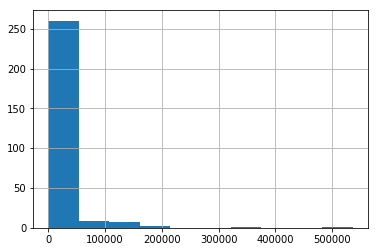

In [56]:
ss = pd.Series(s)
print(ss.describe())
ss[:].hist()
plt.show()

In [ ]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)ss = pd.Series(s)

In [25]:
best = {}
lnames = list(fnames)
for k in tqdm_notebook(gold.keys()):
    ix = lnames.index(add_fname(k))
    test_vec = doc_embeds_reshaped[ix]
    dists = np.sum(np.square(doc_embeds_reshaped - test_vec), 1)
    ixs = dists.argsort()[1:201]
    best[k] = [basename(n).split('.')[0] for n in fnames[ixs]]

median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.065217
acc20     0.076087
acc200    0.179348
dtype: float64


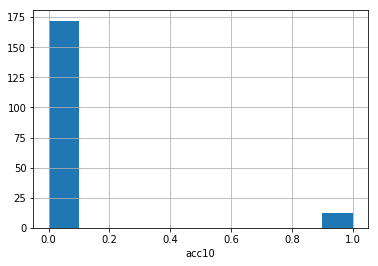

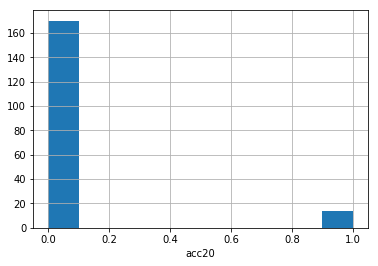

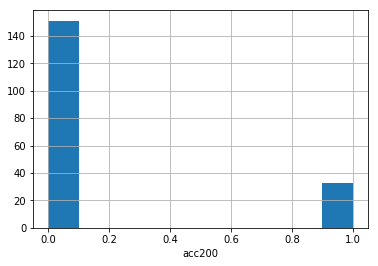

In [42]:
from matplotlib import pyplot as plt

res = evaluate(best, gold)

In [30]:
def evaluate(preds, gold):
    result = []
    for key, val in preds.items():
        true_val = gold[key]
        gold_len = len(true_val)

        inter10 = set(val[0:10]).intersection(true_val)
        inter20 = set(val[0:20]).intersection(true_val)
        inter200 = set(val[0:200]).intersection(true_val)

        acc10 = len(inter10)/gold_len
        acc20 = len(inter20)/gold_len
        acc200 = len(inter200)/gold_len

        result.append([acc10, acc20, acc200])

    result = pd.DataFrame(result, columns=['acc10', 'acc20', 'acc200'])
    
    print('median')
    print(result.median(axis=0))
    
    print('mean')
    print(result.mean(axis=0))
    
    ax = result['acc10'].hist()
    ax.set_xlabel("acc10")
    plt.show()
    
    ax = result['acc20'].hist()
    ax.set_xlabel("acc20")
    plt.show()
    
    ax = result['acc200'].hist()
    ax.set_xlabel("acc200")
    plt.show()
    
    return result


# Develop

In [21]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        dense = tf.convert_to_tensor([[1,2],[3,4]])
        
        shape = tf.shape(dense)
        dense = tf.pad(dense, [[0,10-shape[0]], [0,5-shape[1]]], 'CONSTANT')
        dense.set_shape([n_sents, n_words])

                
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([dense])
        print(res)

#         train_writer = tf.summary.FileWriter('../data/summary', sess.graph)

[[1 2 0 0 0]
 [3 4 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [59]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():
        
        r = list(range(100))
        ziped = zip(r[:-1], r[1:])
        t = tf.convert_to_tensor(ziped)
        
        def f(el):
            return el[0]
        
#         elems = np.array([1, 2, 3, 4, 5, 6])
#         squares = tf.map_fn(lambda x: x * x, elems)

        
        m = tf.map_fn(f, t)
            
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]


In [38]:
tt

array([[  0,   1],
       [  1,   2],
       [  2,   3],
       ..., 
       [996, 997],
       [997, 998],
       [998, 999]], dtype=int32)